# Accurately predicting human essential genes based on deep learning

This section will present a comparative analysis to demonstrate the application and performance of PyTorch models for addressing sequence-based prediction problems.

We'll try to replicate the [DeepHE: Accurately predicting human essential genes based on deep learning](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1008229) deep learning model and evaluate its performance. Other models will be compared to the DeepHE model.

DeepHE's model is based on the multilayer perceptron structure. It includes one input layer, three hidden layers, and one output layer. All the hidden layers utilize the ReLU activation function. The output layer uses sigmoid activation function to perform discrete classification. The loss function in DeepHE is binary cross-entropy. A dropout layer is used after each hidden layer.

In [363]:
%load_ext autoreload
import pandas as pd
import matplotlib.pyplot as plt
from os.path import exists
import pickle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


At this point, there is already 2 cleaned datasets which will be used in this notebook.
- `deg.csv`: 16 datasets grouped that contain essential genes of the human genome. Each sequence has an EMBL id associated, the original dataset it came from, among other information. [Link](http://origin.tubic.org/deg/public/index.php)
- `negative.csv`: contains the genome DNA sequences of humans for all annotated genes from Ensembl. Each sequence has an EMBL id associated. [Link](http://www.ensembl.org/Homo_sapiens/Info/Index)

The process of cleaning each dataset is described below:
- `deg.csv`:
    - removed rows with unavailable sequences.
- `negative.csv`:
    - removed all rows which sequences belonged to the `deg.csv` dataset.
    - removed all rows which EMBL id was in the `deg.csv` dataset.
    - grouped all sequences with the same EMBL id, and kept only the first two.

One of the tasks in this notebook is to also build the positive dataset (`essential_genes_positve.csv`), which will contain only the sequences that are in at least 5 different datasets.

In [364]:
deg_dataset = pd.read_csv("datasets/essential_genes/deg.csv", sep=';')
print(deg_dataset.shape)

eg_negative = pd.read_csv("datasets/essential_genes/negative.csv", sep=',')
print(eg_negative.shape)

(26791, 15)
(27684, 2)


Creating positive essential genes dataset. Each sequence needs to be in at least 5 datasets.

In [365]:
# for each sequence, get all the datasets that contain it
d = {}
for _, row in deg_dataset.iterrows():
    if(row["sequence"] in d):
        d[row["sequence"]].append((row["id1"], row["id4"]))
    else:
        d[row["sequence"]] = [(row["id1"], row["id4"])]


# get a list of sequences that are in more than 5 datasets
essential_sequences = []
for key, val in d.items():
    if(len(val) >= 5):
        essential_sequences.append((val[0][1], key))
        
# create dataframe with essential sequences
eg_positive = pd.DataFrame(essential_sequences, columns=["id", "sequence"])
print(eg_positive.head())
print(eg_positive.shape)

# write to csv
eg_positive.to_csv("datasets/essential_genes/positive.csv", index=False)

     id                                           sequence
0  GI:-  ATGGTGCTGTCCCAGAGACAACGAGATGAACTAAATCGAGCTATAG...
1  GI:-  ATGGCTGCAGCTTCATATGATCAGTTGTTAAAGCAAGTTGAGGCAC...
2  GI:-  ATGAGCCGCCTGCTCTGGAGGAAGGTGGCCGGCGCCACCGTCGGGC...
3  GI:-  ATGCAGAGCTGGAGTCGTGTGTACTGCTCCTTGGCCAAGAGAGGCC...
4  GI:-  ATGGTTGGCTATGACCCCAAACCAGATGGCAGGAATAACACCAAGT...
(2010, 2)


In [366]:
print("unique positive sequences:", len(set(eg_positive["sequence"])))
print("unique negative sequences:", len(set(eg_negative["sequence"])))

unique positive sequences: 2010
unique negative sequences: 23443


Even though the negative dataset has 27684 sequences, not all of them are unique. So, we need to remove the duplicates.

In [367]:
eg_negative = eg_negative.drop_duplicates(subset="sequence")
print(eg_negative.shape)

(23443, 2)


At this point, we have both positive and negative datasets:
* eg_positive (2010,  2) -> positive dataset with essential genes 
* eg_negative (23443, 2) -> negative dataset with non essential genes 

Calculating length of each sequence and cleaning up the data.

In [368]:
eg_positive["length"] = eg_positive["sequence"].str.len()
eg_negative["length"] = eg_negative["sequence"].str.len()

In [369]:
print("before removing")
print(eg_positive.shape)
print(eg_negative.shape)

old_eg_positive = eg_positive.shape[0]
old_eg_negative = eg_negative.shape[0]

eg_positive = eg_positive[eg_positive["length"] <= 20000]
eg_negative = eg_negative[eg_negative["length"] <= 20000]
print("after removing")
print(eg_positive.shape, old_eg_positive - eg_positive.shape[0], "were removed")
print(eg_negative.shape, old_eg_negative - eg_negative.shape[0], "were removed")

before removing
(2010, 3)
(23443, 3)
after removing
(2010, 3) 0 were removed
(23439, 3) 4 were removed


Joining the positive and negative datasets

In [370]:
# adding labels to the dataset
eg_positive["label"] = 1
eg_negative["label"] = 0

# removing length column
eg_positive = eg_positive.drop(columns=["length"])
eg_negative = eg_negative.drop(columns=["length"])

# joining the two datasets
dataset = pd.concat([eg_positive, eg_negative])
print(dataset.shape)
print(dataset.head())

(25449, 3)
     id                                           sequence  label
0  GI:-  ATGGTGCTGTCCCAGAGACAACGAGATGAACTAAATCGAGCTATAG...      1
1  GI:-  ATGGCTGCAGCTTCATATGATCAGTTGTTAAAGCAAGTTGAGGCAC...      1
2  GI:-  ATGAGCCGCCTGCTCTGGAGGAAGGTGGCCGGCGCCACCGTCGGGC...      1
3  GI:-  ATGCAGAGCTGGAGTCGTGTGTACTGCTCCTTGGCCAAGAGAGGCC...      1
4  GI:-  ATGGTTGGCTATGACCCCAAACCAGATGGCAGGAATAACACCAAGT...      1


In [371]:
print(dataset.shape)

(25449, 3)


<AxesSubplot:xlabel='label'>

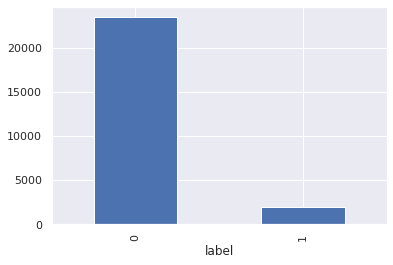

In [372]:
# plot the distribution of each class
dataset.groupby('label').size().plot(kind='bar')

## Classification using DNA descriptors

In [373]:
%load_ext autoreload
%autoreload 2
import sys
import torch
from torch import nn
import os

sys.path.append('../../../../src/')
from propythia.DNA.descriptors.descriptors import DNADescriptor

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [374]:
def calculate_feature(data):
    list_feature = []
    count = 0
    for seq in data['sequence']:
        res = {'sequence': seq}
        dna = DNADescriptor(seq)
        feature = dna.get_descriptors()
        res.update(feature)
        list_feature.append(res)
        # print progress every 100 sequences
        if count % 100 == 0:
            print(count, '/', len(data))

        count += 1
    print("Done!")
    df = pd.DataFrame(list_feature)
    return df

Skip the calculation of descriptors if `features.pkl` exists which already has them calculated. Skip all of this if `fps_x.pkl` exists because it already has the features calculated and **normalized**. The need of data normalization is explained in the next section.

In [375]:
if exists("datasets/essential_genes/fps_x.pkl") == False:
    if exists("datasets/essential_genes/features.pkl"):
        with open("datasets/essential_genes/features.pkl", "rb") as f:
            features = pickle.load(f)
        print("Features loaded from pickle file")
    else:
        features = calculate_feature(dataset)
        with open("datasets/essential_genes/features.pkl", "wb") as f:
            pickle.dump(features, f)
else:
    print("Features already calculated and normalized")

Features already calculated and normalized


Functions to help normalize the data.

Without being normalized, we have a dataset with 17 columns. Each column is a result of a DNA descriptor, and some of these columns are numbers, dicts and even lists.

We still need to normalize those who have dictionaries and lists because the model can't handle data in these types.

To normalize the data, dicts and lists need to "explode" into more columns. 

E.g. dicts:

| descriptor_hello |
| ---------------- |
| {'a': 1, 'b': 2} |

will be transformed into:

| descriptor_hello_a | descriptor_hello_b |
| ------------------ | ------------------ |
| 1                  | 2                  |

E.g. lists:

| descriptor_hello |
| ---------------- |
| [1, 2, 3]        |

will be transformed into:

| descriptor_hello_0 | descriptor_hello_1 | descriptor_hello_2 |
| ------------------ | ------------------ | ------------------ |
| 1                  | 2                  | 3                  |

In [376]:
def process_lists(fps_x, field):
    l = fps_x[field].to_list()
    new_df = pd.DataFrame(l)
    new_df.columns = [str(field) + "_" + str(i) for i in new_df.columns]
    fps_x.drop(field, axis=1, inplace=True)
    return new_df

def process_lists_of_lists(fps_x, field):
    l = fps_x[field].to_list()
    new_df = pd.DataFrame(l)
    new_df.columns = [str(field) + "_" + str(i) for i in new_df.columns]
    empty_val = {} if field == "enhanced_nucleic_acid_composition" else []
    small_processed = []
    for f in new_df.columns:
        col = [empty_val if i is None else i for i in new_df[f].to_list()]
        sub = pd.DataFrame(col)
        sub.columns = [str(f) + "_" + str(i) for i in sub.columns]
        small_processed.append(sub)
    fps_x.drop(field, axis=1, inplace=True)
    return small_processed

In [377]:
def normalize_features():
    fps_y = dataset['label']
    fps_x = features.loc[:, features.columns != 'label']
    fps_x = fps_x.loc[:, fps_x.columns != 'sequence']
    print(fps_x.shape)
    
    lists = ["nucleic_acid_composition","dinucleotide_composition","trinucleotide_composition","k_spaced_nucleic_acid_pairs","kmer","PseDNC", "PseKNC", "DAC", "DCC", "DACC", "TAC","TCC","TACC"]
    lists_of_lists = [
        "accumulated_nucleotide_frequency"
    ]

    small_processed = []
    for i in lists:
        new_df = process_lists(fps_x, i)
        small_processed.append(new_df)
        
    for i in lists_of_lists:
        smaller_processed = process_lists_of_lists(fps_x, i)
        small_processed += smaller_processed

    # concat final with original
    fps_x = pd.concat([fps_x, *small_processed], axis=1)

    with open("datasets/essential_genes/fps_x.pkl", "wb") as f:
        pickle.dump(fps_x, f)
        
    with open("datasets/essential_genes/fps_y.pkl", "wb") as f:
        pickle.dump(fps_y, f)
    
    return fps_x, fps_y

Skip the data normalization if it was already performed (`fps_x.pkl` exists).

In [378]:
if exists("datasets/essential_genes/fps_x.pkl"):
    with open("datasets/essential_genes/fps_x.pkl", "rb") as f:
        fps_x = pickle.load(f)
    with open("datasets/essential_genes/fps_y.pkl", "rb") as f:
        fps_y = pickle.load(f)
    print("Features loaded from pickle file")
else:
    fps_x, fps_y = normalize_features()
fps_x

Features loaded from pickle file


,length,gc_content,at_content,nucleic_acid_composition_A,nucleic_acid_composition_C,nucleic_acid_composition_G,nucleic_acid_composition_T,dinucleotide_composition_AA,dinucleotide_composition_AC,dinucleotide_composition_AG,...,accumulated_nucleotide_frequency_0_G,accumulated_nucleotide_frequency_0_T,accumulated_nucleotide_frequency_1_A,accumulated_nucleotide_frequency_1_C,accumulated_nucleotide_frequency_1_G,accumulated_nucleotide_frequency_1_T,accumulated_nucleotide_frequency_2_A,accumulated_nucleotide_frequency_2_C,accumulated_nucleotide_frequency_2_G,accumulated_nucleotide_frequency_2_T
0,1233,0.440,0.560,0.303,0.193,0.247,0.256,0.096,0.052,0.075,...,0.224,0.247,0.324,0.182,0.227,0.267,0.321,0.188,0.240,0.251
1,8532,0.412,0.588,0.344,0.208,0.205,0.244,0.126,0.054,0.089,...,0.240,0.250,0.336,0.193,0.220,0.251,0.345,0.198,0.211,0.246
2,3720,0.604,0.396,0.215,0.290,0.314,0.181,0.041,0.050,0.089,...,0.340,0.153,0.205,0.311,0.322,0.162,0.208,0.303,0.319,0.171
3,1530,0.414,0.586,0.303,0.169,0.246,0.282,0.099,0.044,0.080,...,0.248,0.290,0.298,0.163,0.247,0.292,0.301,0.164,0.244,0.291
4,963,0.559,0.441,0.212,0.286,0.273,0.229,0.048,0.045,0.076,...,0.282,0.224,0.199,0.286,0.278,0.237,0.213,0.289,0.267,0.230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25444,576,0.439,0.561,0.288,0.210,0.229,0.273,0.089,0.068,0.068,...,0.229,0.312,0.292,0.181,0.215,0.312,0.296,0.206,0.208,0.289
25445,576,0.434,0.566,0.286,0.212,0.222,0.280,0.089,0.068,0.066,...,0.229,0.312,0.292,0.181,0.215,0.312,0.296,0.206,0.208,0.289
25446,3363,0.394,0.606,0.338,0.192,0.202,0.268,0.122,0.055,0.076,...,0.193,0.262,0.353,0.190,0.196,0.262,0.351,0.187,0.198,0.264
25447,1101,0.633,0.367,0.227,0.292,0.341,0.140,0.037,0.056,0.105,...,0.295,0.175,0.227,0.292,0.323,0.158,0.225,0.293,0.340,0.142


In [379]:
%load_ext autoreload
%autoreload 2
from src.models import MLP
from src.train import traindata
from src.test import test
from src.prepare_data import prepare_data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Training the model and evaluating the performance

In [380]:
torch.manual_seed(2022)
os.environ["CUDA_VISIBLE_DEVICES"] = '4,5'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# ----------------------------------------------------------------------

epochs = 50
optimizer_label = 'adam'
loss_function = nn.CrossEntropyLoss(weight=torch.tensor([1.0, 4.0]).to(device))
patience = 2 # patience for early stopping
input_size = fps_x.shape[1]
hidden_size = 128 # devia estar na config
dropout = 0.2
output_size = 2

# ----------------------------------------------------------------------

# these are hyperparameters to be tuned
config = {
    'lr': 0.001,
    'batch_size': 32,
    'hidden_size': 128,
}

model = MLP(input_size, hidden_size, output_size, dropout).to(device)

trainloader, testloader, validloader = prepare_data(
    fps_x, fps_y, 
    mode='descriptors',
    batch_size=paramDict['batch_size'],
)
model = traindata(device, model, trainloader, validloader, epochs, optimizer_label, loss_function, paramDict['patience'])

# Test
acc, mcc, report = test(device, model, testloader)
print('Accuracy: %.3f' % acc)
print('MCC: %.3f' % mcc)
print(report)

x_train.shape: (15269, 247)
y_train.shape: (15269,)
x_test.shape: (5090, 247)
y_test.shape: (5090,)
x_cv.shape: (5090, 247)
y_cv.shape: (5090,)
[1/50, 0/478] loss: 0.69612831
[1/50, 100/478] loss: 0.54193211
[1/50, 200/478] loss: 0.50137359
[1/50, 300/478] loss: 0.59616804
[1/50, 400/478] loss: 0.56707215
The Current Loss: 0.5241906262934208
trigger times: 0
[2/50, 0/478] loss: 0.36132064
[2/50, 100/478] loss: 0.4450371
[2/50, 200/478] loss: 0.72435057
[2/50, 300/478] loss: 0.46684515
[2/50, 400/478] loss: 0.57613087
The Current Loss: 0.5171113163232803
trigger times: 0
[3/50, 0/478] loss: 0.43871167
[3/50, 100/478] loss: 0.57861805
[3/50, 200/478] loss: 0.53417456
[3/50, 300/478] loss: 0.57263094
[3/50, 400/478] loss: 0.64933813
The Current Loss: 0.5355154132470489
Trigger Times: 1
[4/50, 0/478] loss: 0.34381378
[4/50, 100/478] loss: 0.46595493
[4/50, 200/478] loss: 0.61688215
[4/50, 300/478] loss: 0.63536489
[4/50, 400/478] loss: 0.52198923
The Current Loss: 0.5150763653218746
trigge

## Classification using One hot encoding

Statistics about the data, including:
* Total sequences
* Top 5 longest and shortest sequences
* Average length of sequences
* Top 5 most and least common sequence length

In [381]:
# def stats(dataset):
#     dataset["length"].hist(bins=100)
#     plt.show()

#     print("-" * 40)

#     print("Total sequences:", dataset.shape[0])

#     print("-" * 40)

#     print("Top 5 longest sequences:")
#     print("id       length")
#     print(dataset["length"].nlargest(5).to_string())

#     print("-" * 40)

#     print("Top 5 shortest sequences:")
#     print("id       length")
#     print(dataset["length"].nsmallest(5).to_string())

#     print("-" * 40)

#     average_length = dataset["length"].mean()
#     print("Average length:", average_length)

#     print("-" * 40)

#     print("Top 5 most common lengths:")
#     print("length   count")
#     print(dataset["length"].value_counts().nlargest(5).to_string())
    
#     print("-" * 40)

#     print("Top 5 least common lengths:")
#     print("length   count")
#     print(dataset["length"].value_counts().nsmallest(5).to_string())

In [382]:
# stats(eg_positive)
# print("*" * 100)
# stats(eg_negative)

# eg_positive = eg_positive.drop(columns=["length"])
# eg_negative = eg_negative.drop(columns=["length"])

In [383]:
# import torch
# import torch.utils.data as data_utils
# import src.encoding as enc
# import os
# from torch import nn
# from torch.optim import Adam

Without using descriptors and using one hot encoding, all sequences need to have the same length. So, some sequences will be truncated or padded with Ns.

In [384]:
# fps_x = dataset['sequence'].values
# fps_y = dataset['label'].values

# average_length = int(average_length)

# cut sequences to the average length
# seqs_dataset = seqs_dataset.str.slice(0, average_length)

# fill with "N" the sequences that are shorter than average length
# seqs_dataset = seqs_dataset.str.pad(average_length, side='right', fillchar='N')

We need now to split the dataset into training, test and validation sets.

In [385]:
# x, x_test, y, y_test = train_test_split(
#     fps_x, fps_y,
#     test_size=0.2,
#     train_size=0.8,
#     stratify=fps_y
# )
# x_train, x_cv, y_train, y_cv = train_test_split(
#     x, y,
#     test_size=0.25,
#     train_size=0.75,
#     stratify=y
# )

# print(fps_x.shape)
# print(fps_y.shape)

Now we need to one hot encode the sequences.

In [386]:
# x_train_enc = enc.DNAEncoding(x_train)
# x_train = x_train_enc.one_hot_encode()

# x_test_enc = enc.DNAEncoding(x_test)
# x_test = x_test_enc.one_hot_encode()

# x_cv_enc = enc.DNAEncoding(x_cv)
# x_cv = x_cv_enc.one_hot_encode()

# print(x_train.shape)
# print(y_train.shape)
# print(x_test.shape)
# print(y_test.shape)
# print(x_cv.shape)
# print(y_cv.shape)

In [387]:
# # convert to torch.tensor
# train_data = data_utils.TensorDataset(
#     torch.tensor(x_train, dtype=torch.float),
#     torch.tensor(y_train, dtype=torch.long)
# )
# test_data = data_utils.TensorDataset(
#     torch.tensor(x_test, dtype=torch.float),
#     torch.tensor(y_test, dtype=torch.long)
# )
# valid_data = data_utils.TensorDataset(
#     torch.tensor(x_cv, dtype=torch.float),
#     torch.tensor(y_cv, dtype=torch.long)
# )

# batch_size = 16

# # Data loader
# trainloader = data_utils.DataLoader(
#     train_data,
#     shuffle=True,
#     batch_size=batch_size
# )
# testloader = data_utils.DataLoader(
#     test_data,
#     shuffle=True,
#     batch_size=batch_size
# )
# validloader = data_utils.DataLoader(
#     valid_data,
#     shuffle=True,
#     batch_size=batch_size
# )

Building the model equivalent to the one in the paper.

In [388]:
# from src.models import MLP
# from src.train import traindata
# from src.test import test

In [389]:
# torch.manual_seed(2022)
# os.environ["CUDA_VISIBLE_DEVICES"] = '4,5'
# device = torch.device('cuda:0')

# model = MLP().to(device)

# paramDict = {
#     'epoch': 200,
#     'batchSize': 32,
#     'dropOut': 0.2,
#     'learning_rate': 0.004,
#     'loss': nn.CrossEntropyLoss(),
#     'metrics': ['accuracy'],
#     'activation1': 'relu',
#     'activation2': 'sigmoid',
#     'monitor': 'val_accuracy',
#     'save_best_only': True,
#     'mode': 'max'
# }

# class_weight = {0: 1.0, 1: 4.0}

# optimizerDict = {
#     'adam': Adam(model.parameters(), learning_rate=0.001, beta_1=0.9, beta_2=0.999),
# }

In [390]:
# # epochs = 100
# # lr = 0.004
# # loss_function = nn.CrossEntropyLoss()

# #optimizer = Adam(model.parameters(), lr=lr)

# model = traindata(device, model, paramDict['epochs'], optimizerDict['adam'], paramDict['loss'], trainloader, validloader)

# acc, mcc, report = test(device, model, testloader)
# print('Accuracy: %.3f' % acc)
# print('MCC: %.3f' % mcc)
# print(report)